In [1]:
%matplotlib inline
from pylab import *
rcParams['figure.figsize'] = 16, 6
import numpy as np
import ipywidgets

# Mean Shift Tracking

## Changing Colorspaces
Recall that OpenCV by default reads color images as BGR images. Color channels are represented by the 3rd dimension of the image array.

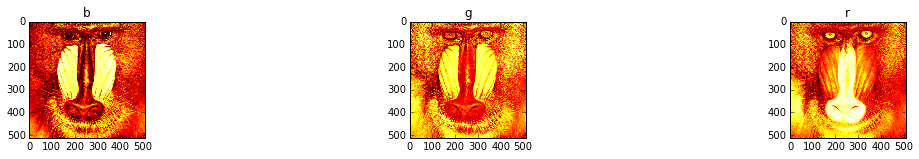

In [2]:
import cv2
img_bgr = cv2.imread('mandrill.png')
subplot(3,3,1);title('b');imshow(img_bgr[:,:,0],cmap='hot');
subplot(3,3,2);title('g');imshow(img_bgr[:,:,1],cmap='hot');
subplot(3,3,3);title('r');imshow(img_bgr[:,:,2],cmap='hot');
tight_layout()

 Converting colorspaces is easy with **cv2.cvtColor**. For example, changing from BGR to RGB colorspace merely reverses the channel order.

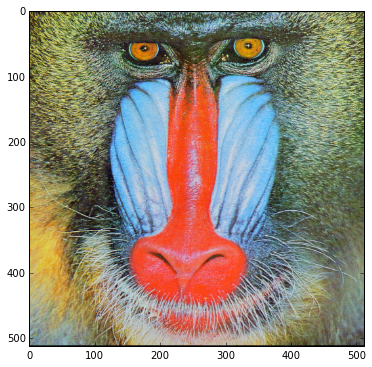

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
imshow(img_rgb);

The following shows conversion to HSV colorspace. 

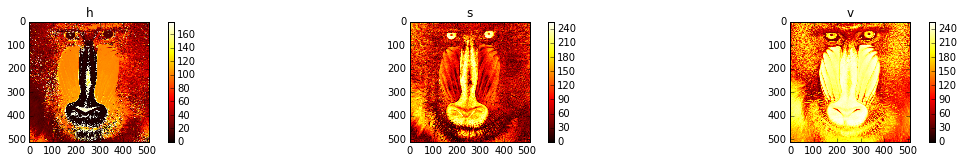

In [4]:
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
subplot(3,3,4);title('h');imshow(img_hsv[:,:,0],cmap='hot');colorbar()
subplot(3,3,5);title('s');imshow(img_hsv[:,:,1],cmap='hot');colorbar()
subplot(3,3,6);title('v');imshow(img_hsv[:,:,2],cmap='hot');colorbar()
tight_layout()

### Understanding Hue
Note that when OpenCV converts a uint8 array to HSV, the Hue is in the range $(0,180]$ which describes the $\dfrac{angle}{2}$ in the hue circle. Lets visualize the colors of each hue valu:

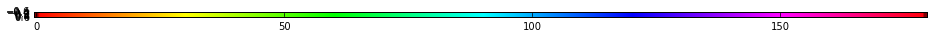

In [5]:
colormap_hsv = np.ones((1,180,3), dtype=np.uint8)*255
colormap_hsv[0,:,0] = np.arange(180)
colormap_rgb = cv2.cvtColor(colormap_hsv, cv2.COLOR_HSV2RGB)
imshow(colormap_rgb);

## Color Histograms
Lets analyze the histogram of hue values using **cv2.calcHist**:

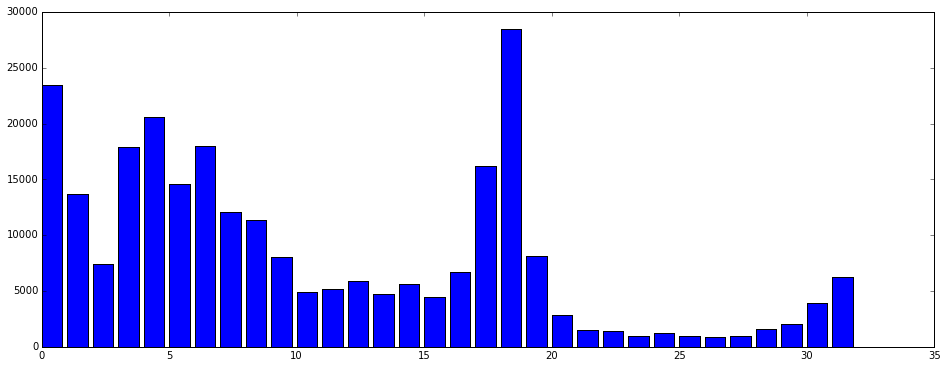

In [6]:
hue_hist = cv2.calcHist([img_hsv], [0], None, [32], [0, 180])
bar(range(len(hue_hist)), hue_hist);


We see that there's a peak between bins 15 and 20, where the hue Cyan is dominant. We can use the function **cv2.inRange** to select only the pixels that fit in that range:

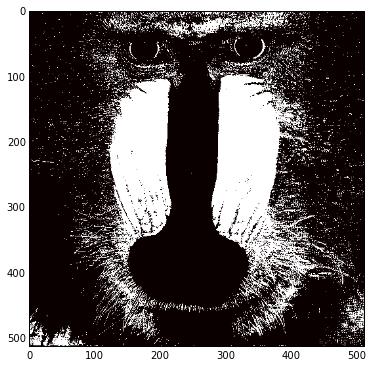

In [7]:
bin_size = 180/32.0
mask = cv2.inRange(img_hsv, np.array((bin_size*15, 0, 0)), np.array((bin_size*20, 255., 255.)))
_ = imshow(mask, cmap='hot')

Indeed we see that the cyan areas in the image were selected.

## Back Projection

Now lets select the ROI that covers the Mandril's left eye, and extract its hue histogram and normalize its values to the uint8 range using **cv2.normalize**:

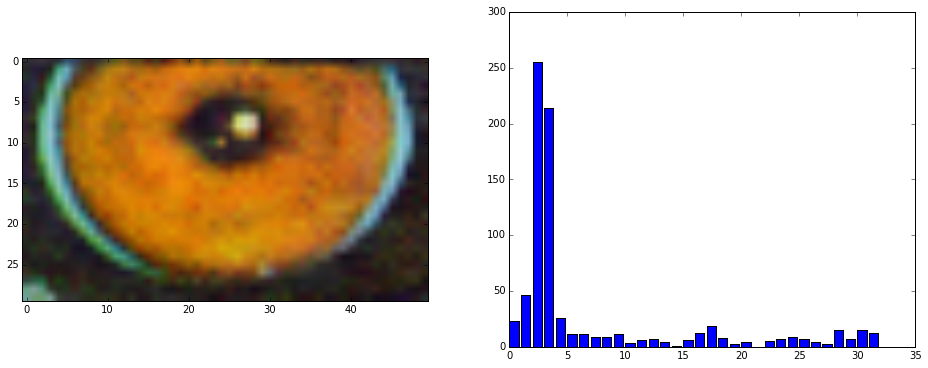

In [8]:
subplot(121); imshow(img_rgb[50:80,150:200])
hue_eye_hist = cv2.calcHist([img_hsv[50:80,150:200]], [0], None, [32], [0, 180])
cv2.normalize(hue_eye_hist, hue_eye_hist, 0, 255, cv2.NORM_MINMAX)
subplot(122); bar(range(len(hue_eye_hist)), hue_eye_hist);

We see that the left eye is mainly described by the Orange hue. Using **cv2.calcBackProject** we can apply the learned color model on the entire image:

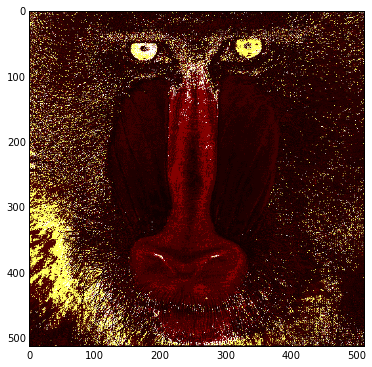

In [9]:
prob = cv2.calcBackProject([img_hsv], [0], hue_eye_hist, [0, 180], 1)
imshow(prob,cmap='hot');

We can see that the right eye also has a strong response to the learned color model.

## Mean Shift

Now we will see how to use the learned color model to obtain an accurate localization of the right eye from a coarse initial estimation using **cv2.meanShift**:

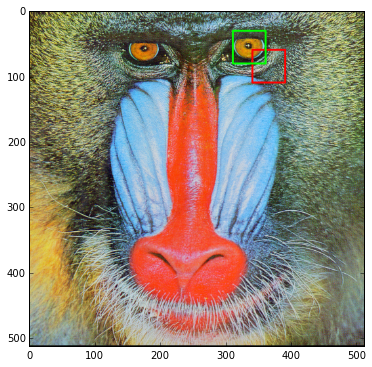

In [10]:
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)
initial_rect = (340,60,50,50) # x,y,width,height
track_box, final_rect = cv2.meanShift(prob, initial_rect, term_crit)

def draw_rect(rect, color, canvas):
    cv2.rectangle(canvas, rect[:2], (rect[0]+rect[2],rect[1]+rect[3]), color, 2)

canvas = np.array(img_rgb)
draw_rect(initial_rect, (255,0,0), canvas)
draw_rect(final_rect, (0,255,0), canvas)
imshow(canvas);

### Mean Shift Convergence
The following shows the convergence process by interactively limiting the number of iterations:

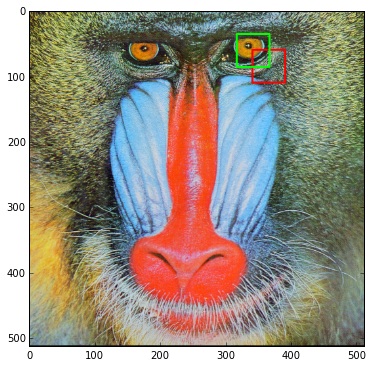

In [11]:
def show_frame(ind):    
    term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, ind, 1)
    initial_rect = (340,60,50,50)
    track_box, final_rect = cv2.meanShift(prob, initial_rect, term_crit)    
    canvas = np.array(img_rgb)
    draw_rect(initial_rect, (255,0,0), canvas)
    draw_rect(final_rect, (0,255,0), canvas)
    imshow(canvas)
    
_ = ipywidgets.interact(show_frame, ind=(1,6), continuous_update=False)